# CLASSIFICATION: BANK FULL

## Relevant Information

   The data is related with direct marketing campaigns of a Portuguese banking institution. 
   The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, 
   in order to access if the product (bank term deposit) would be (or not) subscribed. 

Number of Instances: 45211 for bank-full.csv

Number of Attributes: 16 + output attribute.

### Attribute information

   Input variables:
   
   1. age (numeric)
   
   2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
                                       
   3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   
   4. education (categorical: "unknown","secondary","primary","tertiary")
   
   5. default: has credit in default? (binary: "yes","no")
   
   6. balance: average yearly balance, in euros (numeric) 
   
   7. housing: has housing loan? (binary: "yes","no")
   
   8. loan: has personal loan? (binary: "yes","no")
   
   9. contact: contact communication type (categorical: "unknown","telephone","cellular") 

   
  10. day: last contact day of the month (numeric)
  
  11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  
  12. duration: last contact duration, in seconds (numeric)
  
  13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15. previous: number of contacts performed before this campaign and for this client (numeric)
  
  16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  
  17. y: has the client subscribed a term deposit? (binary: "yes","no")

## IMPORT LIBRARY

In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

from scipy import stats as ss
import statsmodels.api as sm

# Encode
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder

# Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# Selection
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

# Modeling
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, recall_score, roc_auc_score, roc_curve, precision_score, f1_score

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Ensembel
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, StackingClassifier, GradientBoostingClassifier

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from imblearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from imblearn import FunctionSampler

## OVERVIEW

Import dataset

In [2]:
df = pd.read_csv("bank-full.csv", delimiter=";")

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Dataset Information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
pd.DataFrame({'Features': df.columns,
              'dataType': df.dtypes.values,
              'nullvalues': [df[i].isna().sum() for i in df.columns],
              'unique': [df[i].nunique() for i in df.columns],
              'uniqueSample': [list(pd.Series(df[i].unique()))
                               for i in df.columns]}).reset_index(drop=True)

,Features,dataType,nullvalues,unique,uniqueSample
0,age,int64,0,77,"[58, 44, 33, 47, 35, 28, 42, 43, 41, 29, 53, 5..."
1,job,object,0,12,"[management, technician, entrepreneur, blue-co..."
2,marital,object,0,3,"[married, single, divorced]"
3,education,object,0,4,"[tertiary, secondary, unknown, primary]"
4,default,object,0,2,"[no, yes]"
5,balance,int64,0,7168,"[2143, 29, 2, 1506, 1, 231, 447, 121, 593, 270..."
6,housing,object,0,2,"[yes, no]"
7,loan,object,0,2,"[no, yes]"
8,contact,object,0,3,"[unknown, cellular, telephone]"
9,day,int64,0,31,"[5, 6, 7, 8, 9, 12, 13, 14, 15, 16, 19, 20, 21..."


> There is 17 columns with 45211 row without missing values

Show tendency

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [7]:
df.describe(exclude=['int', 'float']).T

,count,unique,top,freq
job,45211,12,blue-collar,9732
marital,45211,3,married,27214
education,45211,4,secondary,23202
default,45211,2,no,44396
housing,45211,2,yes,25130
loan,45211,2,no,37967
contact,45211,3,cellular,29285
month,45211,12,may,13766
poutcome,45211,4,unknown,36959
y,45211,2,no,39922


Show heatmap correlation untuk melihat korelasi antar kolom

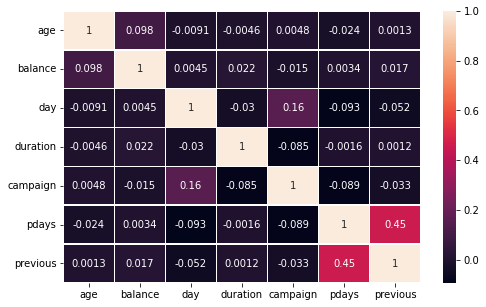

In [8]:
plt.figure(figsize=(8, 5))
sns.heatmap(df.corr("pearson"), linewidths=0.5, annot=True)
plt.show()

Displays a numerical data distribution plot

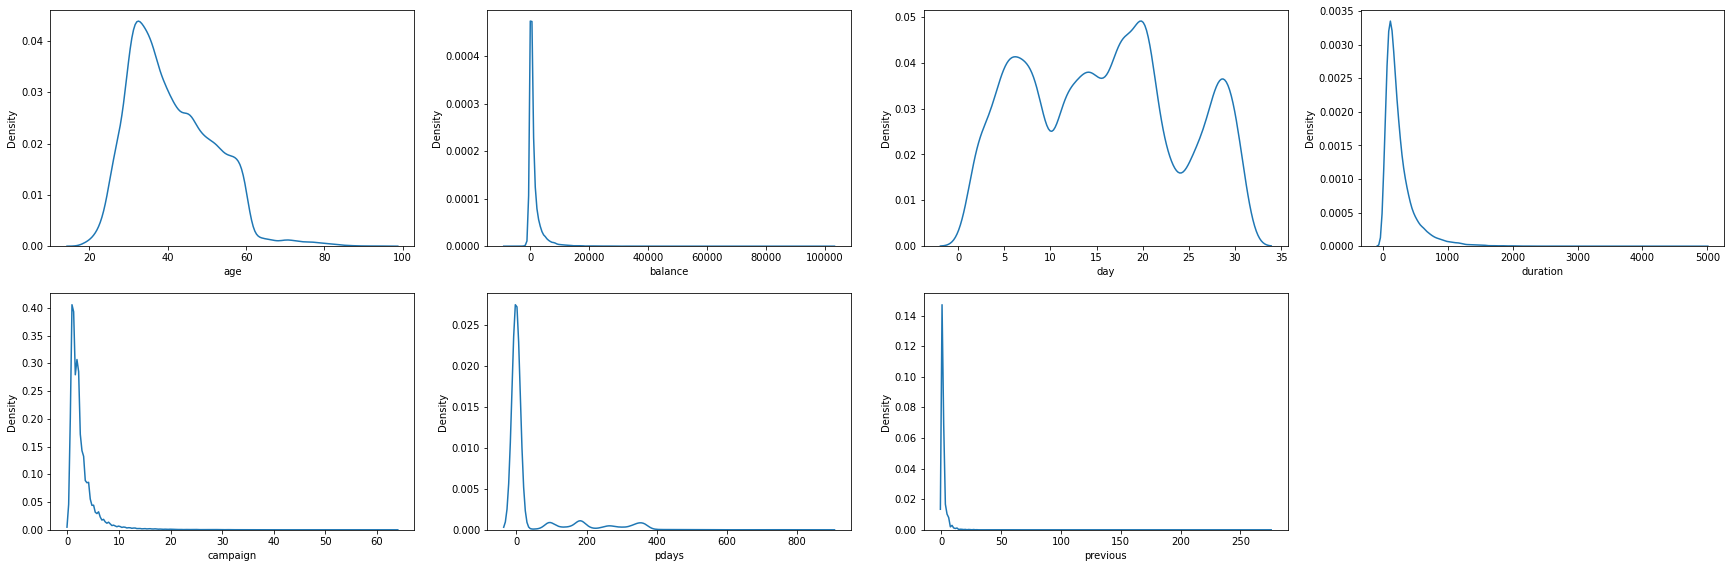

In [9]:
df_num = df.select_dtypes(exclude=object).columns
plt.figure(figsize=(30, 20))
for i in range(0, len(df_num)):
    plt.subplot(4, 4, i+1)
    sns.kdeplot(x=df[df_num[i]])
    plt.xlabel(df_num[i])

## PREPROCESSING

Drop columns that we feel have nothing to do with analysis

In [10]:
df = df.drop(columns=["day", "month", "contact", "duration", "pdays", "previous"])

### Outlier Handling

Displays the numeric data boxplot to see the outliers

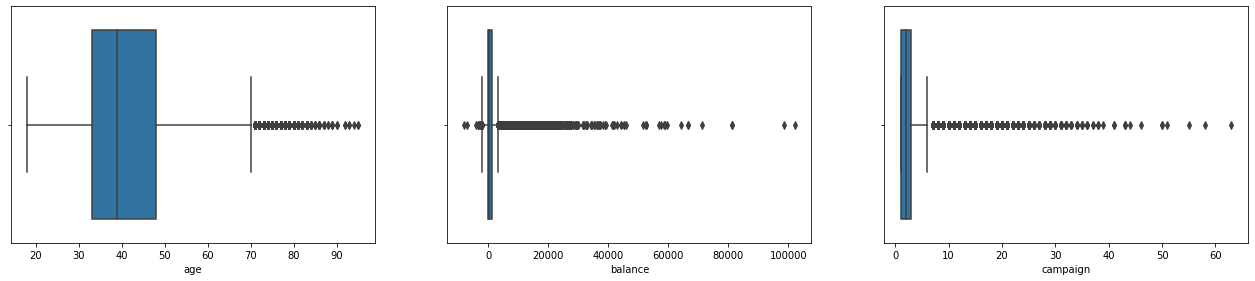

In [11]:
df_num = df.select_dtypes(exclude=object).columns
plt.figure(figsize=(30, 20))
for i in range(0, len(df_num)):
    plt.subplot(4, 4, i+1)
    sns.boxplot(df[df_num[i]])
    plt.xlabel(df_num[i])

In [12]:
df_new = df.copy()

Handling outliers with winsorizing

In [13]:
def handling_outliers(data):
    print(data.upper())
    print("Data awal")
    plt.figure(figsize=(10, 6))
    sns.boxplot(df[data])
    plt.title(f"Boxplot data {data}")
    plt.show()

    iqr = df[data].quantile(.75) - df[data].quantile(.25)
    lower_limit = df[data].quantile(.25) - 1.5 * iqr
    upper_limit = df[data].quantile(.75) + 1.5 * iqr

    low_out = []
    upper_out = []

    for i in df[data]:
        if (i < lower_limit):
            low_out.append(i)
        if (i > upper_limit):
            upper_out.append(i)

    print("Lower Limit:", lower_limit)
    print("Upper Limit:", upper_limit)
    print("Jumlah Data :", len(df))
    print("Jumlah Outliers:", len(low_out)+len(upper_out))
    print("Perc Outliers :", round((len(low_out)+len(upper_out)/len(df))*100, 2), "%")

    index = 1
    while index > 0.75:
        quantile_temp = df[data].quantile(index)
        if quantile_temp >= upper_limit:
            index = index - 0.01
        else:
            break

    low_index = 0
    while low_index < 0.25:
        quantile_temp = df[data].quantile(low_index)
        if quantile_temp < lower_limit:
            low_index = low_index + 0.0001
        else:
            break

    index_dif = 1 - index
    df_new[data] = ss.mstats.winsorize(df[data], limits=(low_index, index_dif))

    print("\nSetelah dilakukan winsorizing")
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_new[data], palette="Accent", orient="h")
    plt.show()

    iqr = df_new[data].quantile(.75) - df_new[data].quantile(.25)
    lower_limit = df_new[data].quantile(.25) - 1.5 * iqr
    upper_limit = df_new[data].quantile(.75) + 1.5 * iqr

    low_out = []
    upper_out = []

    for i in df_new[data]:
        if (i < lower_limit):
            low_out.append(i)
        if (i > upper_limit):
            upper_out.append(i)

    print("Lower Limit:", lower_limit)
    print("Upper Limit:", upper_limit)
    print("Jumlah Data :", len(df))
    print("Jumlah Outliers:", len(low_out)+len(upper_out))
    print("Perc Outliers :", round((len(low_out)+len(upper_out)/len(df))*100, 2), "%")
    print("\n")

AGE
Data awal


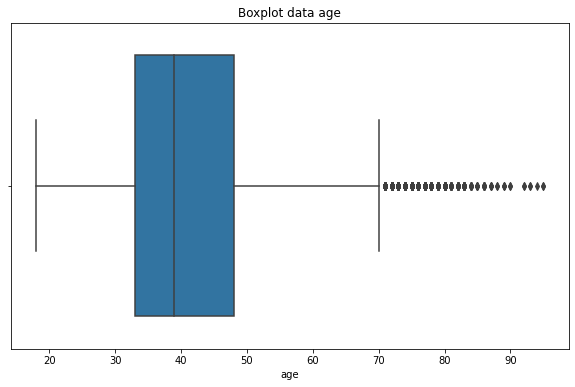

Lower Limit: 10.5
Upper Limit: 70.5
Jumlah Data : 45211
Jumlah Outliers: 487
Perc Outliers : 1.08 %

Setelah dilakukan winsorizing


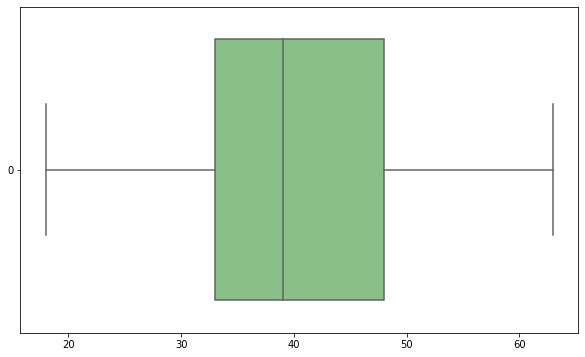

Lower Limit: 10.5
Upper Limit: 70.5
Jumlah Data : 45211
Jumlah Outliers: 0
Perc Outliers : 0.0 %




In [14]:
handling_outliers("age")

BALANCE
Data awal


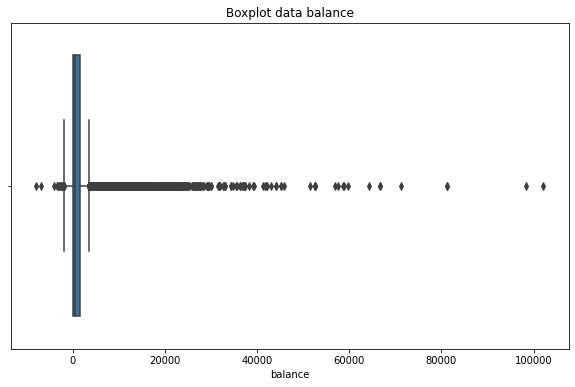

Lower Limit: -1962.0
Upper Limit: 3462.0
Jumlah Data : 45211
Jumlah Outliers: 4729
Perc Outliers : 1710.42 %

Setelah dilakukan winsorizing


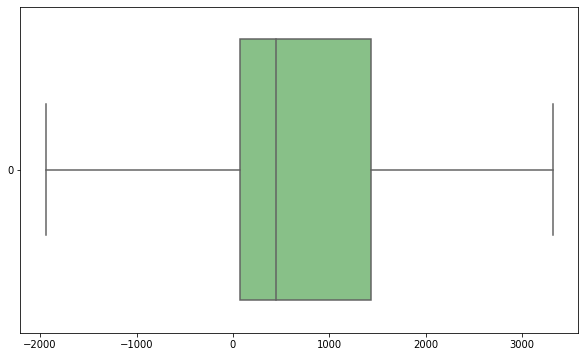

Lower Limit: -1962.0
Upper Limit: 3462.0
Jumlah Data : 45211
Jumlah Outliers: 0
Perc Outliers : 0.0 %




In [15]:
handling_outliers("balance")

CAMPAIGN
Data awal


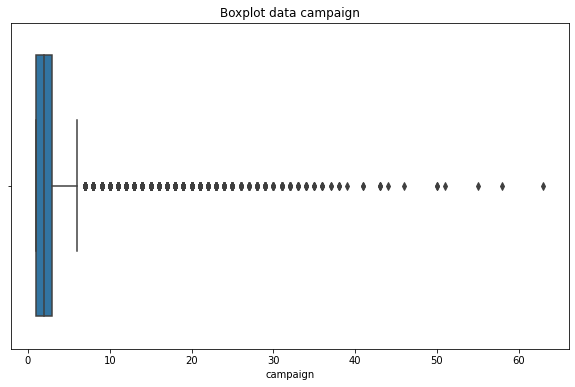

Lower Limit: -2.0
Upper Limit: 6.0
Jumlah Data : 45211
Jumlah Outliers: 3064
Perc Outliers : 6.78 %

Setelah dilakukan winsorizing


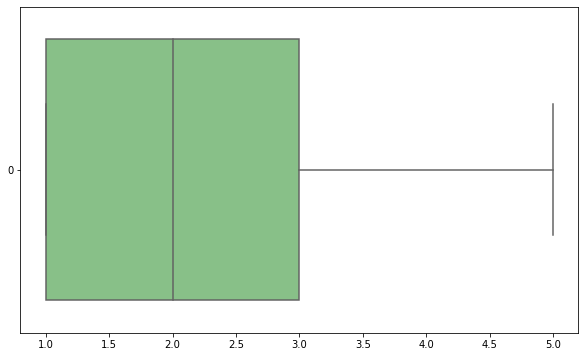

Lower Limit: -2.0
Upper Limit: 6.0
Jumlah Data : 45211
Jumlah Outliers: 0
Perc Outliers : 0.0 %




In [16]:
handling_outliers("campaign")

In [18]:
df_new.head()

,age,job,marital,education,default,balance,housing,loan,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,1,unknown,no
1,44,technician,single,secondary,no,29,yes,no,1,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,1,unknown,no
4,33,unknown,single,unknown,no,1,no,no,1,unknown,no


## FEATURE ENGINEERING

### Encoding

In [43]:
df_enc = df_new.copy()

Changing categorical data by encoding

In [44]:
df_enc["y"] = LabelEncoder().fit_transform(df_enc["y"])

In [45]:
class_order = ["unknown", "other", "failure", "success"]
df_enc["poutcome"] = OrdinalEncoder(categories=[class_order]).fit_transform(df_enc[["poutcome"]])
df_enc.head()

,age,job,marital,education,default,balance,housing,loan,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,1,0.0,0
1,44,technician,single,secondary,no,29,yes,no,1,0.0,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,0.0,0
3,47,blue-collar,married,unknown,no,1506,yes,no,1,0.0,0
4,33,unknown,single,unknown,no,1,no,no,1,0.0,0


In [46]:
class_order = ["unknown", "secondary", "primary", "tertiary"]
df_enc["education"] = OrdinalEncoder(categories=[class_order]).fit_transform(df_enc[["education"]])
df_enc.head()

,age,job,marital,education,default,balance,housing,loan,campaign,poutcome,y
0,58,management,married,3.0,no,2143,yes,no,1,0.0,0
1,44,technician,single,1.0,no,29,yes,no,1,0.0,0
2,33,entrepreneur,married,1.0,no,2,yes,yes,1,0.0,0
3,47,blue-collar,married,0.0,no,1506,yes,no,1,0.0,0
4,33,unknown,single,0.0,no,1,no,no,1,0.0,0


In [47]:
df_enc = pd.get_dummies(df_enc,
                        columns=['marital', 'job',
                                 'default', 'housing',
                                 'loan'], drop_first=True)
df_enc.head()

,age,education,balance,campaign,poutcome,y,marital_married,marital_single,job_blue-collar,job_entrepreneur,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_yes,housing_yes,loan_yes
0,58,3.0,2143,1,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,44,1.0,29,1,0.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,33,1.0,2,1,0.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,47,0.0,1506,1,0.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,33,0.0,1,1,0.0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


### Scaling

In [48]:
df_scl = df_enc.copy()

Scale the data so that the scale units of the entire column are similar to MinMaxScaler

In [49]:
scaler = MinMaxScaler()
df_scl['age'] = scaler.fit_transform(df_scl[['age']])
df_scl['balance'] = scaler.fit_transform(df_scl[['balance']])
df_scl['campaign'] = scaler.fit_transform(df_scl[['campaign']])

In [50]:
df_scl.head()

,age,education,balance,campaign,poutcome,y,marital_married,marital_single,job_blue-collar,job_entrepreneur,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_yes,housing_yes,loan_yes
0,0.888889,3.0,0.776131,0.0,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.577778,1.0,0.374382,0.0,0.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,0.333333,1.0,0.369251,0.0,0.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0.644444,0.0,0.655074,0.0,0.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0.333333,0.0,0.369061,0.0,0.0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


### Feature Importance

Looking for features to be used in modeling

In [51]:
X = df_scl.drop(['y'], axis=1)
y = df_scl["y"].values.reshape(-1, 1)

In [52]:
model = ExtraTreesClassifier()
model.fit(X, y)
print(model.feature_importances_)

[0.29130896 0.04298262 0.38638052 0.06095595 0.10396525 0.01011749
 0.00865197 0.00624807 0.00404004 0.0033387  0.00694303 0.00571546
 0.00467935 0.00565149 0.00514773 0.00867118 0.00437207 0.00173553
 0.00325867 0.02483231 0.01100362]


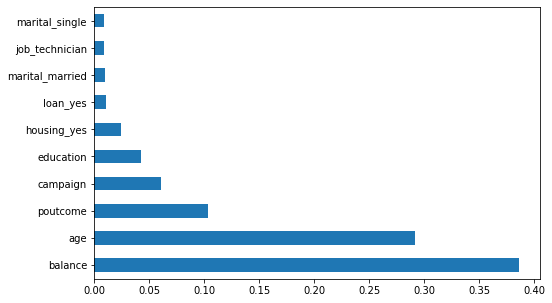

In [53]:
plt.figure(figsize=(8, 5))
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind="barh")
plt.show()

In [59]:
col = feat_importances.nlargest(9).index.tolist()

In [63]:
df_fi = df_scl[col].copy()
df_fi["y"] = df_scl["y"]
df_fi.head()

,balance,age,poutcome,campaign,education,housing_yes,loan_yes,marital_married,job_technician,y
0,0.776131,0.888889,0.0,0.0,3.0,1,0,1,0,0
1,0.374382,0.577778,0.0,0.0,1.0,1,0,0,1,0
2,0.369251,0.333333,0.0,0.0,1.0,1,1,1,0,0
3,0.655074,0.644444,0.0,0.0,0.0,1,0,1,0,0
4,0.369061,0.333333,0.0,0.0,0.0,0,0,0,0,0


## LOGISTIC REGRESSION

Split data train (80%) and test (20%)

In [64]:
X = df_fi.drop(['y'], axis=1)
y = df_fi["y"].values.reshape(-1, 1)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [66]:
model = LogisticRegression()

### Basic

In [67]:
model.fit(X_train, y_train)

LogisticRegression()

In [68]:
y_pred = model.predict(X_test)

#### Basic Model Evaluation

Evaluate the model with confusion matrix, classification report, AUC score, and train & test score

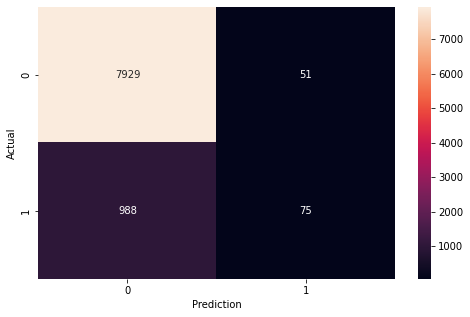

In [69]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [70]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7980
           1       0.60      0.07      0.13      1063

    accuracy                           0.89      9043
   macro avg       0.74      0.53      0.53      9043
weighted avg       0.85      0.89      0.84      9043



In [71]:
def plot_roc_curve(true_y, y_prob, labels):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.5320820277410365



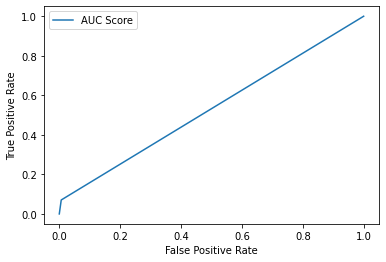

In [72]:
plot_roc_curve(y_test, y_pred, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred)}\n")
plt.show()

In [73]:
pd.DataFrame(data=[model.score(X_train, y_train)*100,
                   model.score(X_test, y_test)*100],
             index=['Model Score in Data Train', 'Model Score in Data Test'],
             columns=['Score (%)'])

,Score (%)
Model Score in Data Train,88.852024
Model Score in Data Test,88.510450


### Optimize

#### Imbalanced Data Handling

Doing data balancing, but because we want to increase the precision value, we don't do data balancing

In [ ]:
# balanced = TomekLinks()
# X_train, y_train = balanced.fit_resample(X_train, y_train)

#### Hypermarameter Tuning

Looking for the best hyperparameter, so that the percentage in classification can increase

In [74]:
param = [{'solver': ['saga'],
          'penalty': ['elasticnet', 'l1', 'l2', 'none'],
          'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
          'C': [0.01, 0.1, 1],
          'l1_ratio': [0, 1]},

         {'solver': ['newton-cg', 'lbfgs'],
          'penalty': ['l2', 'none'],
          'max_iter': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
          'C': [0.01, 0.1, 1],
          'l1_ratio': [0, 1]}]

In [75]:
model_ht = RandomizedSearchCV(estimator=model, param_distributions=param, cv=5, scoring="f1")

##### Random Search

Perform hyperparameter tuning process with random search

In [76]:
model_ht.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=LogisticRegression(),
                   param_distributions=[{'C': [0.01, 0.1, 1],
                                         'l1_ratio': [0, 1],
                                         'max_iter': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                         'penalty': ['elasticnet', 'l1', 'l2',
                                                     'none'],
                                         'solver': ['saga']},
                                        {'C': [0.01, 0.1, 1],
                                         'l1_ratio': [0, 1],
                                         'max_iter': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100],
                                         'penalty': ['l2', 'none'],
                                         'solver': ['newton-cg', 'lbfgs']}],
                   scoring='f1')

In [77]:
model_ht.best_params_

{'solver': 'newton-cg',
 'penalty': 'none',
 'max_iter': 60,
 'l1_ratio': 0,
 'C': 0.01}

In [78]:
model_ht_tuned = LogisticRegression(solver="newton-cg", penalty="none", max_iter=60, C=0.01, l1_ratio=0)
model_ht_tuned.fit(X_train, y_train)

LogisticRegression(C=0.01, l1_ratio=0, max_iter=60, penalty='none',
                   solver='newton-cg')

###### Report

Displays cross validation on train and test data, correlation matrix, AUC score, and train & test score

In [79]:
scores_train = cross_val_score(model_ht_tuned, X_train, y_train, scoring='accuracy', cv=5)
for i, j in enumerate(scores_train):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.89
fold no. - 3, score: 0.89
fold no. - 4, score: 0.89


In [80]:
scores_test = cross_validate(model_ht_tuned, X_train, y_train, cv=5)
for i, j in enumerate(scores_test["test_score"]):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.89
fold no. - 3, score: 0.89
fold no. - 4, score: 0.89


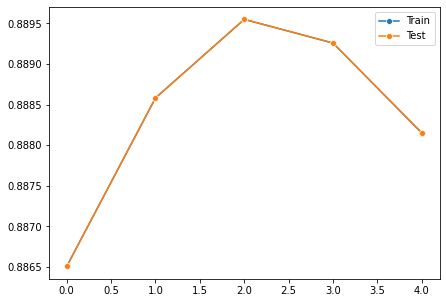

In [81]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=scores_train, label="Train", marker="o")
sns.lineplot(data=scores_test["test_score"], label="Test", marker="o")
plt.show()

In [82]:
print("Train Score: ", scores_train.mean())
print("Test Score: ",  scores_test["test_score"].mean())
print("Score Diff: ", round((scores_train.mean() - scores_test["test_score"].mean())*100, 2))

Train Score:  0.8884096601906883
Test Score:  0.8884096601906883
Score Diff:  0.0


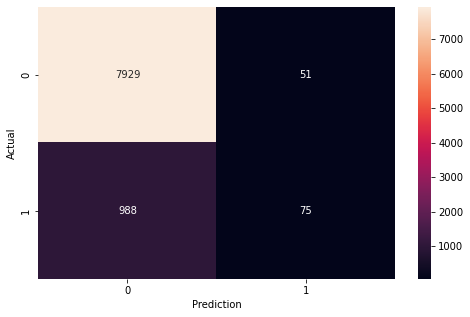

In [83]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [84]:
y_pred_ht_tuned = model_ht_tuned.predict(X_test)
print(classification_report(y_test, y_pred_ht_tuned))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      7980
           1       0.59      0.07      0.13      1063

    accuracy                           0.88      9043
   macro avg       0.74      0.53      0.53      9043
weighted avg       0.85      0.88      0.84      9043



In [85]:
def plot_roc_curve(true_y, y_prob, labels):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.5320193710994325



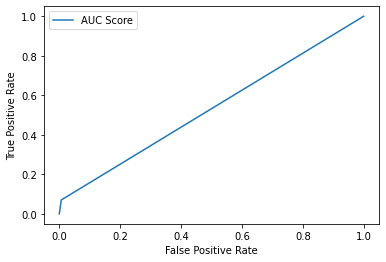

In [86]:
plot_roc_curve(y_test, y_pred_ht_tuned, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred_ht_tuned)}\n")
plt.show()

In [87]:
pd.DataFrame(data=[model_ht_tuned.score(X_train, y_train)*100,
                   model_ht_tuned.score(X_test, y_test)*100],
             index=['Model Score in Data Train', 'Model Score in Data Test'],
             columns=['Score (%)'])

,Score (%)
Model Score in Data Train,88.849259
Model Score in Data Test,88.499392


## DECISION TREE CLASSIFIER

Perform classification with a decision tree model

In [88]:
df = pd.read_csv("bank-full.csv", delimiter=";")
df = df.drop(columns=["day", "month", "contact", "duration", "pdays", "previous"])
df.head()

,age,job,marital,education,default,balance,housing,loan,campaign,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,1,unknown,no
1,44,technician,single,secondary,no,29,yes,no,1,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,1,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,1,unknown,no
4,33,unknown,single,unknown,no,1,no,no,1,unknown,no


In [89]:
df["y"] = LabelEncoder().fit_transform(df_enc["y"])

class_order = ["unknown", "other", "failure", "success"]
df["poutcome"] = OrdinalEncoder(categories=[class_order]).fit_transform(df[["poutcome"]])

class_order = ["unknown", "secondary", "primary", "tertiary"]
df["education"] = OrdinalEncoder(categories=[class_order]).fit_transform(df[["education"]])

df = pd.get_dummies(df, columns=['marital', 'job',
                                 'default', 'housing',
                                 'loan'], drop_first=True)

,age,education,balance,campaign,poutcome,y,marital_married,marital_single,job_blue-collar,job_entrepreneur,...,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,default_yes,housing_yes,loan_yes
0,1.266667,3.0,1.250000,1,0.0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.333333,1.0,-0.308997,1,0.0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
2,-0.400000,1.0,-0.328909,1,0.0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,1,1
3,0.533333,0.0,0.780236,1,0.0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,-0.400000,0.0,-0.329646,1,0.0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
scaler = RobustScaler()
df['age'] = scaler.fit_transform(df[['age']])
df['balance'] = scaler.fit_transform(df[['balance']])

df.head()

In [90]:
X = df.drop(columns="y")
y = df["y"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

### Basic Decision Tree

Doing modeling with decision tree

In [92]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [93]:
y_pred = model.predict(X_test)

result = pd.DataFrame()
result["y_act"] = y_test
result["y_pred"] = y_pred
result.head()

,y_act,y_pred
14001,0,0
32046,1,0
13318,0,0
42991,0,0
14237,0,0


In [94]:
DT_cols = X_train.columns.tolist()

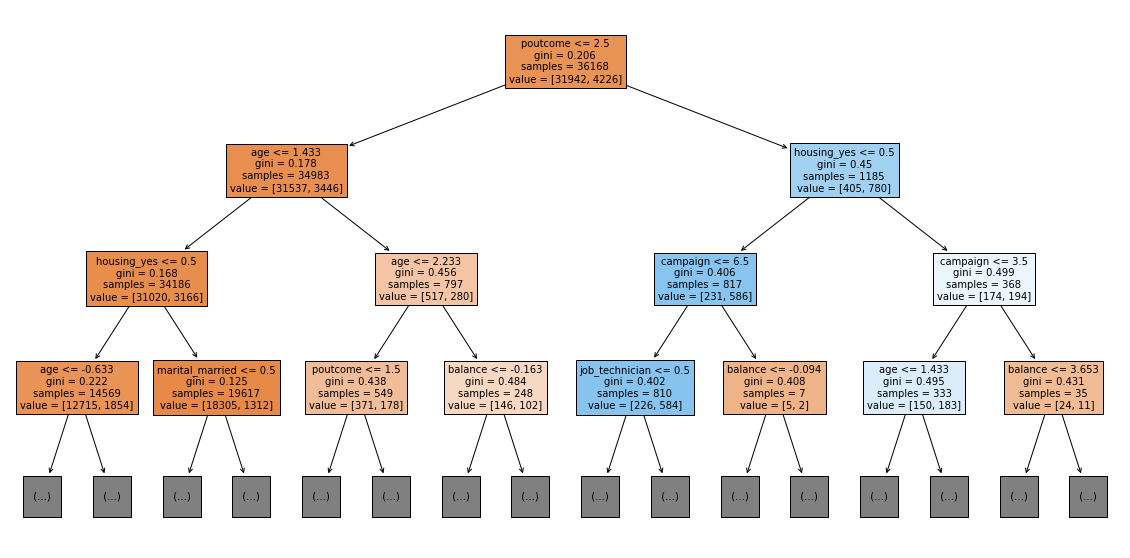

In [95]:
plt.figure(figsize=(20, 10))
plot_tree(model,
          feature_names=DT_cols, impurity=True,
          fontsize=10, max_depth=3,
          filled=True)
plt.show()

#### Report

Displays confusion matrix and classification report

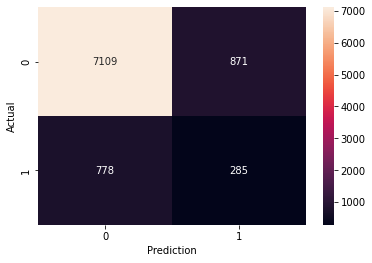

In [96]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt=".0f")
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [97]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.90      7980
           1       0.25      0.27      0.26      1063

    accuracy                           0.82      9043
   macro avg       0.57      0.58      0.58      9043
weighted avg       0.82      0.82      0.82      9043



### Optimize

Doing decision tree modeling with optimization

#### Imbalanced Data Handling

The process of balancing data so that the target data has the same comparison, but in this dataset, data balancing will not be carried out because it wants to increase the percentage precision

In [ ]:
# balanced = TomekLinks()
# X_train, y_train = balanced.fit_resample(X_train, y_train)

#### Hypermarameter Tuning

Perform the hyperparameter tuning process to find the best hyperparameter value, so as to increase the precision value

In [98]:
param = [{'max_depth': [2, 3, 5, 10, 20],
          'min_samples_leaf': [5, 10, 20, 50, 100],
          'criterion': ["gini", "entropy"]}]

In [99]:
model = DecisionTreeClassifier()

##### Grid Search

Using the grid search method to perform hyperparameter tuning

In [100]:
model_ht = GridSearchCV(estimator=model, param_grid=param, cv=5)

In [101]:
model_ht.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid=[{'criterion': ['gini', 'entropy'],
                          'max_depth': [2, 3, 5, 10, 20],
                          'min_samples_leaf': [5, 10, 20, 50, 100]}])

In [102]:
model_ht.best_params_

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 50}

In [103]:
model_ht_tuned = DecisionTreeClassifier(min_samples_leaf=50, max_depth=5, criterion='entropy')
model_ht_tuned.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50)

In [104]:
y_pred = model_ht_tuned.predict(X_test)

result = pd.DataFrame()
result["y_act"] = y_test
result["y_pred"] = y_pred
result.head()

,y_act,y_pred
14001,0,0
32046,1,0
13318,0,0
42991,0,0
14237,0,0


In [105]:
DT_cols = X_train.columns.tolist()

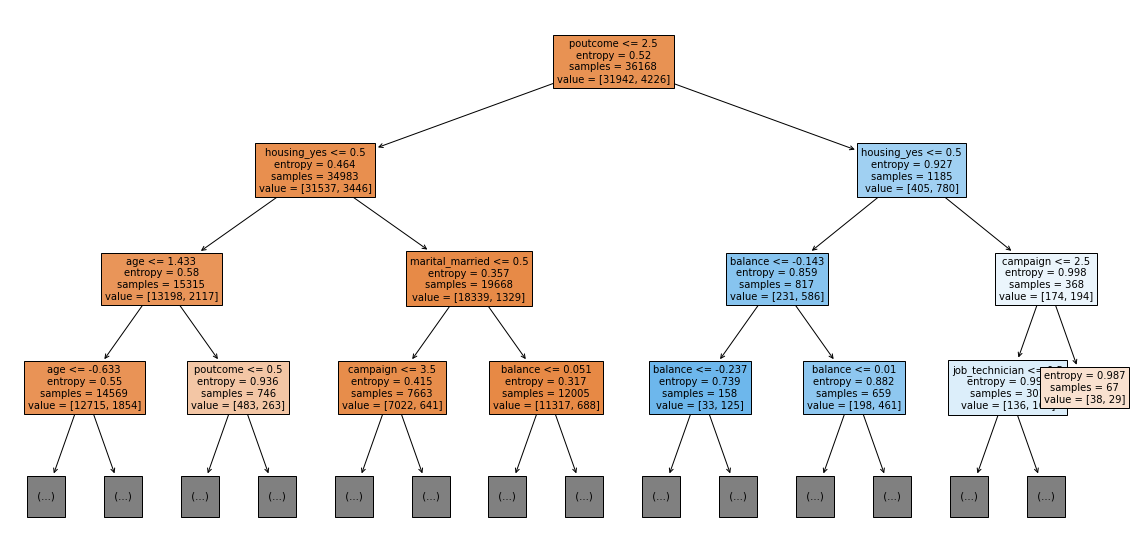

In [106]:
plt.figure(figsize=(20, 10))
plot_tree(model_ht_tuned,
          feature_names=DT_cols, impurity=True,
          fontsize=10, max_depth=3,
          filled=True)
plt.show()

#### Report


Display cross validation score, confusion matrix, classification report, AUC score, and train & test score

In [107]:
scores_train = cross_val_score(model_ht_tuned, X_train, y_train, scoring='accuracy', cv=5)
for i, j in enumerate(scores_train):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.9
fold no. - 3, score: 0.89
fold no. - 4, score: 0.89


In [108]:
scores_test = cross_validate(model_ht_tuned, X_train, y_train, cv=5)
for i, j in enumerate(scores_test["test_score"]):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.9
fold no. - 3, score: 0.89
fold no. - 4, score: 0.89


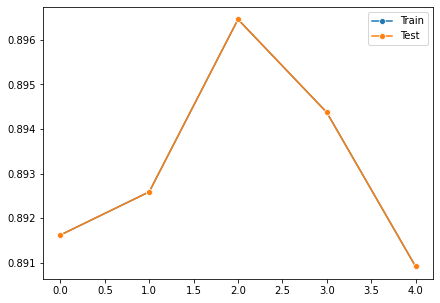

In [109]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=scores_train, label="Train", marker="o")
sns.lineplot(data=scores_test["test_score"], label="Test", marker="o")
plt.show()

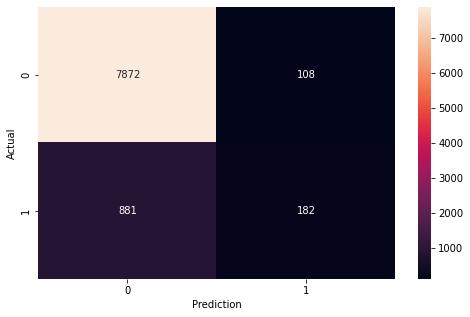

In [110]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [111]:
y_pred_ht_tuned = model_ht_tuned.predict(X_test)
print(classification_report(y_test, y_pred_ht_tuned))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7980
           1       0.63      0.17      0.27      1063

    accuracy                           0.89      9043
   macro avg       0.76      0.58      0.60      9043
weighted avg       0.87      0.89      0.86      9043



In [112]:
def plot_roc_curve(true_y, y_prob, labels):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.5788398559899278



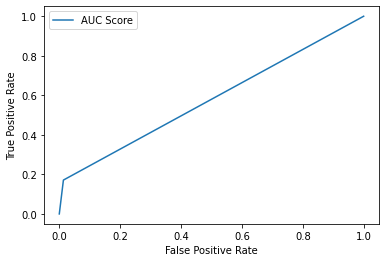

In [113]:
plot_roc_curve(y_test, y_pred_ht_tuned, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred_ht_tuned)}\n")
plt.show()

In [114]:
pd.DataFrame(data=[model_ht_tuned.score(X_train, y_train)*100,
                   model_ht_tuned.score(X_test, y_test)*100],
             index=['Model Score in Data Train', 'Model Score in Data Test'],
             columns=['Score (%)'])

,Score (%)
Model Score in Data Train,89.396704
Model Score in Data Test,89.063364


## ENSEMBLE LEARNING

Using Random Forest, ExtraTreesClassifier, AdaBoost Classifier, and Gradient Boosting Classifier models to see which model works best

In [115]:
rf_pipe = Pipeline([('model', RandomForestClassifier())])
et_pipe = Pipeline([('model', ExtraTreesClassifier())])
ab_pipe = Pipeline([('model', AdaBoostClassifier())])
gb_pipe = Pipeline([('model', GradientBoostingClassifier())])

In [116]:
models = [rf_pipe, et_pipe, ab_pipe, gb_pipe]
models

[Pipeline(steps=[('model', RandomForestClassifier())]),
 Pipeline(steps=[('model', ExtraTreesClassifier())]),
 Pipeline(steps=[('model', AdaBoostClassifier())]),
 Pipeline(steps=[('model', GradientBoostingClassifier())])]

In [117]:
def cv_score(model, data_x, data_y, scoring, n):
    cv = KFold(n_splits=n, shuffle=False)
    scores_train = cross_val_score(model, data_x, data_y, scoring=scoring, cv=cv)
    scores_test = cross_validate(model, data_x, data_y, cv=n)

    return scores_train.mean(), scores_test["test_score"].mean()

In [118]:
for i in range(len(models)):
    models[i].fit(X_train, y_train)
    preds = models[i].predict(X_test)
    print("ensemble model", i)
    print(classification_report(y_test, preds))
    print("CV:", cv_score(models[i], X_train, y_train, "precision", 5))

ensemble model 0
              precision    recall  f1-score   support

           0       0.90      0.97      0.94      7980
           1       0.49      0.20      0.28      1063

    accuracy                           0.88      9043
   macro avg       0.70      0.59      0.61      9043
weighted avg       0.85      0.88      0.86      9043

CV: (0.5000375031702192, 0.8823821110513164)
ensemble model 1
              precision    recall  f1-score   support

           0       0.90      0.95      0.92      7980
           1       0.36      0.21      0.27      1063

    accuracy                           0.86      9043
   macro avg       0.63      0.58      0.60      9043
weighted avg       0.84      0.86      0.85      9043

CV: (0.37205991619414513, 0.8665117803040857)
ensemble model 2
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      7980
           1       0.62      0.16      0.25      1063

    accuracy                           0

Gradient Boosting has the highest precision of all the other models, so in this case you can use gradient boosting as the main model.

### Optimize

#### Hypermarameter Tuning

Looking for the best hyperparameter, so that the percentage in classification can increase

In [124]:
param = {"n_estimators": [i for i in range(1, 300)],
         "max_depth": [1, 3, 5, 7],
         "learning_rate": [0.01, 0.1, 1, 10, 100]}

In [125]:
model = GradientBoostingClassifier()

In [126]:
model_ht = RandomizedSearchCV(estimator=model, param_distributions=param, cv=5, scoring="f1")

##### Grid Search

Perform hyperparameter tuning process with random search

In [127]:
model_ht.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(),
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7],
                                        'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8,
                                                         9, 10, 11, 12, 13, 14,
                                                         15, 16, 17, 18, 19, 20,
                                                         21, 22, 23, 24, 25, 26,
                                                         27, 28, 29, 30, ...]},
                   scoring='f1')

In [128]:
model_ht.best_params_

{'n_estimators': 221, 'max_depth': 1, 'learning_rate': 10}

In [130]:
model_ht_tuned = GradientBoostingClassifier(n_estimators=221, max_depth=1, learning_rate=10)
model_ht_tuned.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=10, max_depth=1, n_estimators=221)

#### Report

Displays cross validation on train and test data, correlation matrix, AUC score, and train & test score

In [131]:
scores_train = cross_val_score(model_ht_tuned, X_train, y_train, scoring='accuracy', cv=5)
for i, j in enumerate(scores_train):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.9
fold no. - 3, score: 0.9
fold no. - 4, score: 0.89


In [132]:
scores_test = cross_validate(model_ht_tuned, X_train, y_train, cv=5)
for i, j in enumerate(scores_test["test_score"]):
    print(f"fold no. - {i}, score: {round(j, 2)}")

fold no. - 0, score: 0.89
fold no. - 1, score: 0.89
fold no. - 2, score: 0.9
fold no. - 3, score: 0.9
fold no. - 4, score: 0.89


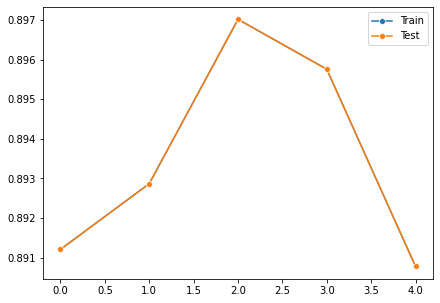

In [133]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=scores_train, label="Train", marker="o")
sns.lineplot(data=scores_test["test_score"], label="Test", marker="o")
plt.show()

In [134]:
print("Train Score: ", scores_train.mean())
print("Test Score: ",  scores_test["test_score"].mean())
print("Score Diff: ", round((scores_train.mean() - scores_test["test_score"].mean())*100, 2))

Train Score:  0.8935246484363191
Test Score:  0.8935246484363191
Score Diff:  0.0


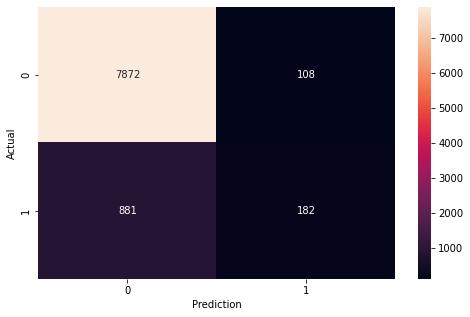

In [135]:
f, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='.0f', ax=ax)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [136]:
y_pred_ht_tuned = model_ht_tuned.predict(X_test)
print(classification_report(y_test, y_pred_ht_tuned))

              precision    recall  f1-score   support

           0       0.90      0.98      0.94      7980
           1       0.61      0.19      0.29      1063

    accuracy                           0.89      9043
   macro avg       0.75      0.59      0.61      9043
weighted avg       0.87      0.89      0.86      9043



In [137]:
def plot_roc_curve(true_y, y_prob, labels):
    fpr, tpr, thresholds = roc_curve(true_y, y_prob)
    sns.lineplot(fpr, tpr, label=labels)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')


model AUC score: 0.585112593336587



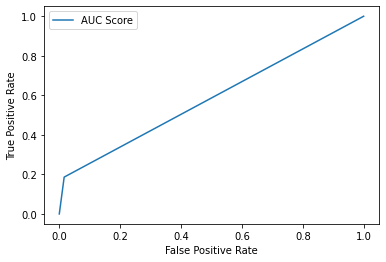

In [138]:
plot_roc_curve(y_test, y_pred_ht_tuned, "AUC Score")
print(f"\nmodel AUC score: {roc_auc_score(y_test, y_pred_ht_tuned)}\n")
plt.show()

In [139]:
pd.DataFrame(data=[model_ht_tuned.score(X_train, y_train)*100,
                   model_ht_tuned.score(X_test, y_test)*100],
             index=['Model Score in Data Train', 'Model Score in Data Test'],
             columns=['Score (%)'])

,Score (%)
Model Score in Data Train,89.352466
Model Score in Data Test,89.019131


## Summary

> In the logistic regression model, it is found that unoptimized logistic regression gets a value of 0.60 in its precision. While the optimized logistic regression gets a value of 0.59 in its precision. So that the unoptimized logistic regression is better than the optimized one, where the optimized one should be better. Preprocessing, Feature Engineering, and data range during hyperparameter tuning can affect the precision value, so further experiments are needed to increase the precision value when optimized.

> In the decision tree model, the precision results are 0.25, this value is very small and optimization is needed with hyperparameter tuning. After doing hyperparameter tuning, a precision result of 0.63 is obtained, where the precision value increases and is considered successful in performing hyperparameter tuning.

> For ensemble learning, it is found that the highest precision value in the gradient boosting model is 0.64, so optimization will be carried out on this model. After optimization, the value of 0.61 is obtained for precision. Precision after optimization drops, the cause is the same as the logistic regression model, where we can experiment again on the preprocessing process, and hyperparameter tuning.